Preprocessing the text...
Total number of words in the text: 722011
Total number of unique words in the text: 6464
['orchestral', 'action']
Creating the lookup table...
Subsampling...
total_number_words 722011
Epoch Number 2/10 Iteration Number: 100 Avg. Training loss: 21.9899
Epoch Number 3/10 Iteration Number: 200 Avg. Training loss: 21.3416
Epoch Number 5/10 Iteration Number: 300 Avg. Training loss: 20.6885
Epoch Number 6/10 Iteration Number: 400 Avg. Training loss: 20.0528
Epoch Number 7/10 Iteration Number: 500 Avg. Training loss: 19.5013
Epoch Number 9/10 Iteration Number: 600 Avg. Training loss: 19.0140
Epoch Number 10/10 Iteration Number: 700 Avg. Training loss: 18.5727
INFO:tensorflow:Restoring parameters from checkpoints/cleaned_wikipedia_version.ckpt


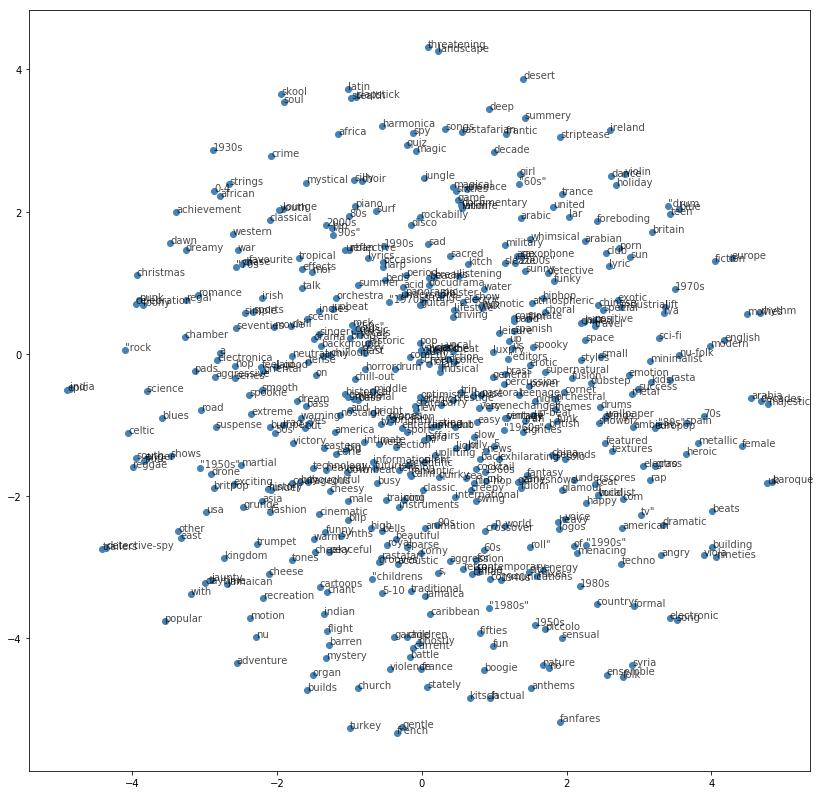

In [25]:
#importing the required packages for this implementation
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#Packages for downloading the dataset
from urllib.request import urlretrieve
from os.path import isfile, isdir

corpus = open("audio_network_sentences_full_stop.txt", "r")
text = corpus.read()
preprocessed_words = [[word.lower() for word in text.split()]][0]
print('Preprocessing the text...')

print("Total number of words in the text: {}".format(len(preprocessed_words)))
print("Total number of unique words in the text: {}".format(len(set(preprocessed_words))))
print(preprocessed_words[:2])

def create_lookuptables(input_words):
    """
    Creating lookup tables for vocan
    Function arguments:
    param words: Input list of words
    """
    input_word_counts = Counter(input_words)
    sorted_vocab = sorted(input_word_counts, key=input_word_counts.get, reverse=True)
    integer_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_integer = {word: ii for ii, word in integer_to_vocab.items()}

    # returning A tuple of dicts
    return vocab_to_integer, integer_to_vocab

print('Creating the lookup table...')
vocab_to_integer, integer_to_vocab = create_lookuptables(preprocessed_words)
integer_words = [vocab_to_integer[word] for word in preprocessed_words]

print('Subsampling...')
# removing unhelpful words
word_threshold = 1e-5

word_counts = Counter(integer_words)
total_number_words = len(integer_words)
# print("word_counts", word_counts)
print("total_number_words", total_number_words)

#Calculating the freqs for the words
frequencies = {word: count/total_number_words for word, count in word_counts.items()}

# #Calculating the discard probability
prob_drop = {word: 1 - np.sqrt(word_threshold/frequencies[word]) for word in word_counts}
training_words = [word for word in integer_words if random.random() < (1 - prob_drop[word])]
# training_words = integer_words

# Defining a function that returns the words around specific index in a specific window
def get_target(input_words, ind, context_window_size=5):
    # selecting random number to be used for genearting words form history and feature of the current word
    rnd_num = np.random.randint(1, context_window_size + 1)
    start_ind = ind - rnd_num if (ind - rnd_num) > 0 else 0
    stop_ind = ind + rnd_num

    target_words = set(input_words[start_ind:ind] + input_words[ind + 1:stop_ind + 1])

    return list(target_words)


# Defining a function for generating word batches as a tuple (inputs, targets)
def generate_random_batches(input_words, train_batch_size, context_window_size=5):
    num_batches = len(input_words) // train_batch_size

    # working on only only full batches
    input_words = input_words[:num_batches * train_batch_size]

    for ind in range(0, len(input_words), train_batch_size):
        input_vals, target = [], []
        input_batch = input_words[ind:ind + train_batch_size]

        # Getting the context for each word
        for ii in range(len(input_batch)):
            batch_input_vals = input_batch[ii]
            batch_target = get_target(input_batch, ii, context_window_size)

            target.extend(batch_target)
            input_vals.extend([batch_input_vals] * len(batch_target))
        yield input_vals, target

train_graph = tf.Graph()

#defining the inputs placeholders of the model
with train_graph.as_default():
    inputs_values = tf.placeholder(tf.int32, [None], name='inputs_values')
    labels_values = tf.placeholder(tf.int32, [None, None], name='labels_values')

num_vocab = len(integer_to_vocab)

num_embedding = 300
with train_graph.as_default():
    embedding_layer = tf.Variable(tf.random_uniform((num_vocab, num_embedding), -1, 1))

    # Next, we are going to use tf.nn.embedding_lookup function to get the output of the hidden layer
    embed_tensors = tf.nn.embedding_lookup(embedding_layer, inputs_values)

# Number of negative labels to sample
num_sampled = 100

with train_graph.as_default():
    # create softmax weights and biases
    softmax_weights = tf.Variable(tf.truncated_normal((num_vocab, num_embedding)))
    softmax_biases = tf.Variable(tf.zeros(num_vocab), name="softmax_bias")

    # Calculating the model loss using negative sampling
    model_loss = tf.nn.sampled_softmax_loss(
        weights=softmax_weights,
        biases=softmax_biases,
        labels=labels_values,
        inputs=embed_tensors,
        num_sampled=num_sampled,
        num_classes=num_vocab)

    model_cost = tf.reduce_mean(model_loss)
    model_optimizer = tf.train.AdamOptimizer().minimize(model_cost)

with train_graph.as_default():
    # set of random words for evaluating similarity on
    valid_num_words = 16
    valid_window = 100

    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent
    valid_samples = np.array(random.sample(range(valid_window), valid_num_words // 2))
    valid_samples = np.append(valid_samples,
                              random.sample(range(1000, 1000 + valid_window), valid_num_words // 2))

    valid_dataset_samples = tf.constant(valid_samples, dtype=tf.int32)

    # Calculating the cosine distance
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding_layer), 1, keep_dims=True))
    normalized_embed = embedding_layer / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embed, valid_dataset_samples)
    cosine_similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embed))
num_epochs = 10
train_batch_size = 1000
contextual_window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration_num = 1
    average_loss = 0

    # Initializing all the vairables
    sess.run(tf.global_variables_initializer())

    for e in range(1, num_epochs + 1):

        # Generating random batch for training
        batches = generate_random_batches(training_words, train_batch_size, contextual_window_size)

        # Iterating through the batch samples
        for input_vals, target in batches:

            # Creating the feed dict
            feed_dict = {inputs_values: input_vals,
                         labels_values: np.array(target)[:, None]}

            train_loss, _ = sess.run([model_cost, model_optimizer], feed_dict=feed_dict)

            # commulating the loss
            average_loss += train_loss

            # Printing out the results after 100 iteration
            if iteration_num % 100 == 0:
                print("Epoch Number {}/{}".format(e, num_epochs),
                      "Iteration Number: {}".format(iteration_num),
                      "Avg. Training loss: {:.4f}".format(average_loss / 100))
                average_loss = 0

            if iteration_num % 1000 == 0:

                ## Using cosine similarity to get the nearest words to a word
                similarity = cosine_similarity.eval()
                for i in range(valid_num_words):
                    valid_word = integer_to_vocab[valid_samples[i]]

                    # number of nearest neighbors
                    top_k = 8
                    nearest_words = (-similarity[i, :]).argsort()[1:top_k + 1]
                    msg = 'The nearest to %s:' % valid_word
                    for k in range(top_k):
                        similar_word = integer_to_vocab[nearest_words[k]]
                        msg = '%s %s,' % (msg, similar_word)
                    print(msg)

            iteration_num += 1
    save_path = saver.save(sess, "checkpoints/cleaned_wikipedia_version.ckpt")
    embed_mat = sess.run(normalized_embed)

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embedding_matrix = sess.run(embedding_layer)

num_visualize_words = 500
tsne_obj = TSNE()
embedding_tsne = tsne_obj.fit_transform(embedding_matrix[:num_visualize_words, :])

fig, ax = plt.subplots(figsize=(14, 14))
for ind in range(num_visualize_words):
    plt.scatter(*embedding_tsne[ind, :], color='steelblue')
    plt.annotate(integer_to_vocab[ind], (embedding_tsne[ind, 0], embedding_tsne[ind, 1]), alpha=0.7)
